In [1]:
import os

In [2]:
%pwd

'/content'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import shutil

# Define source and destination
src_path = "/content/drive/MyDrive/Colab Notebooks/data"
dst_path = "/content/data"

# Copy folder & files
shutil.copytree(src_path, dst_path)

'/content/data'

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [6]:
df = pd.read_csv("data/HAM10000_metadata.csv")

In [7]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


In [9]:
df.isna().sum()

,0
lesion_id,0
image_id,0
dx,0
dx_type,0
age,57
sex,0
localization,0


In [10]:
len(df['image_id'].unique())

10015

In [11]:
len(df['lesion_id'].unique())

7470

In [12]:
df['dx'].unique()

array(['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec'], dtype=object)

In [13]:
label_counts = df['dx'].value_counts()

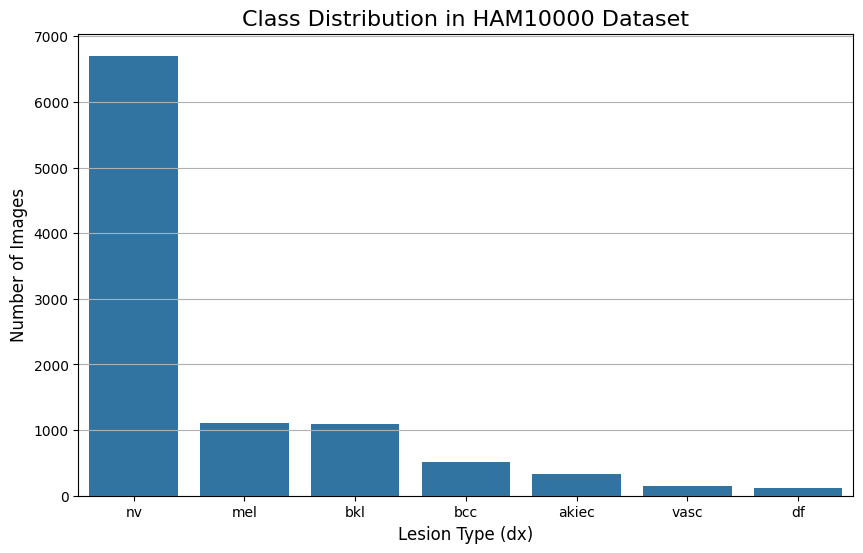

In [14]:
# Plot
plt.figure(figsize=(10,6))
sns.barplot(x=label_counts.index, y=label_counts.values)

plt.title('Class Distribution in HAM10000 Dataset', fontsize=16)
plt.xlabel('Lesion Type (dx)', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.grid(axis='y')
plt.show()

In [15]:
df['image_path'] = df['image_id'].apply(lambda x: f"{x}.jpg") # add image_path column

# Split Dataset (by lesion_id)

In [16]:
from sklearn.model_selection import train_test_split

lesions = df['lesion_id'].unique()

# First split into train+val and test (e.g., 80% train_val, 20% test)
train_val_lesions, test_lesions = train_test_split(lesions, test_size=0.2, random_state=42, stratify=df.groupby('lesion_id')['dx'].first())

# Then split train+val into train and val (e.g., 80% train, 20% val)
train_lesions, val_lesions = train_test_split(train_val_lesions, test_size=0.25, random_state=42, stratify=df[df['lesion_id'].isin(train_val_lesions)].groupby('lesion_id')['dx'].first())

# Create DataFrames
train_df = df[df['lesion_id'].isin(train_lesions)].reset_index(drop=True)
val_df = df[df['lesion_id'].isin(val_lesions)].reset_index(drop=True)
test_df = df[df['lesion_id'].isin(test_lesions)].reset_index(drop=True)

print(f"Train samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")


Train samples: 6045
Validation samples: 1994
Test samples: 1976


# Label Encoding

In [17]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_df['dx'])

train_df['label'] = le.transform(train_df['dx'])
val_df['label'] = le.transform(val_df['dx'])
test_df['label'] = le.transform(test_df['dx'])

print("Classes:", le.classes_)

Classes: ['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc']


In [18]:
train_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,image_path,label
0,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,ISIC_0031633.jpg,2
1,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear,ISIC_0027850.jpg,2
2,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face,ISIC_0029176.jpg,2
3,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face,ISIC_0029068.jpg,2
4,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back,ISIC_0025837.jpg,2


# Calcualate Class Weights (Training Set)

In [19]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['dx']),
    y=df['dx']
)

class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

Class weights: {0: np.float64(4.375273044997815), 1: np.float64(2.78349082823791), 2: np.float64(1.301832835044846), 3: np.float64(12.440993788819876), 4: np.float64(1.2854575792581184), 5: np.float64(0.21338020666879728), 6: np.float64(10.075452716297788)}


# Build Data Pipeline (Preprocessing and Augmentation)

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,            # Normalize pixel values from 0-255 to 0-1
    rotation_range=40,         # Randomly rotate images upto 20 degrees
    horizontal_flip=True,      # Randomly flip images horizontally
    vertical_flip=True,        # Randomly flip images vertically
    zoom_range=0.2             # Randomly zoom images by up to 20%
)

val_datagen = ImageDataGenerator(rescale=1./255)

In [21]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,image_path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,ISIC_0027419.jpg
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,ISIC_0031633.jpg


In [22]:
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory='data/Images_combined_10015',
    x_col='image_path',
    y_col='dx',
    target_size=(224,224),
    class_mode="categorical",
    batch_size=32,
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    directory='data/Images_combined_10015',
    x_col='image_path',
    y_col='dx',
    target_size=(224,224),
    class_mode="categorical",
    batch_size=32,
    shuffle=False
)

Found 6045 validated image filenames belonging to 7 classes.
Found 1994 validated image filenames belonging to 7 classes.


# Load Base Model (VGG16)



In [23]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


image_size = (224,224)
image_shape = image_size + (3,)
num_classes = len(df['dx'].unique())

base_model = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=image_shape
)

for layer in base_model.layers:
    layer.trainable = False  # Freeze so weights don’t change during training


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [24]:
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

# Add custom classification head

In [25]:
x = base_model.output
x = Flatten()(x)
x = Dense(256,activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(num_classes,activation="softmax")(x)

model = Model(inputs=base_model.input,outputs=output_layer)

# Compile the model

In [26]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

In [27]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,139,271 (80.64 MB)

 Trainable params: 6,424,583 (24.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

# Add EarlyStopping




In [28]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# Model Training

In [29]:
if tf.config.list_physical_devices('GPU'):
  print("GPU Available")

GPU Available


In [30]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=40,
    class_weight=class_weights,
    #callbacks=[early_stop]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
189/189 ━━━━━━━━━━━━━━━━━━━━ 171s 832ms/step - accuracy: 0.2012 - loss: 2.0427 - val_accuracy: 0.4022 - val_loss: 1.8000
Epoch 2/40
189/189 ━━━━━━━━━━━━━━━━━━━━ 131s 694ms/step - accuracy: 0.2860 - loss: 1.7216 - val_accuracy: 0.4353 - val_loss: 1.7117
Epoch 3/40
189/189 ━━━━━━━━━━━━━━━━━━━━ 127s 674ms/step - accuracy: 0.3320 - loss: 1.7261 - val_accuracy: 0.5040 - val_loss: 1.5956
Epoch 4/40
189/189 ━━━━━━━━━━━━━━━━━━━━ 127s 670ms/step - accuracy: 0.3654 - loss: 1.5993 - val_accuracy: 0.4022 - val_loss: 1.6672
Epoch 5/40
189/189 ━━━━━━━━━━━━━━━━━━━━ 128s 676ms/step - accuracy: 0.3680 - loss: 1.5982 - val_accuracy: 0.5306 - val_loss: 1.4755
Epoch 6/40
189/189 ━━━━━━━━━━━━━━━━━━━━ 142s 674ms/step - accuracy: 0.4153 - loss: 1.6049 - val_accuracy: 0.4559 - val_loss: 1.6096
Epoch 7/40
189/189 ━━━━━━━━━━━━━━━━━━━━ 126s 666ms/step - accuracy: 0.3682 - loss: 1.5708 - val_accuracy: 0.3300 - val_loss: 1.6196
Epoch 8/40
189/189 ━━━━━━━━━━━━━━━━━━━━ 127s 671ms/step - accuracy: 0.3650 -

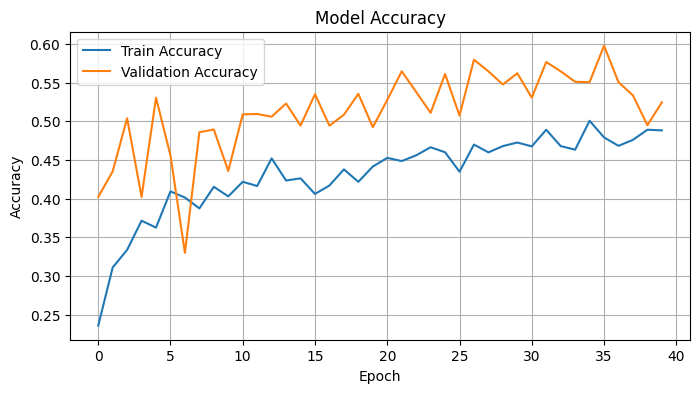

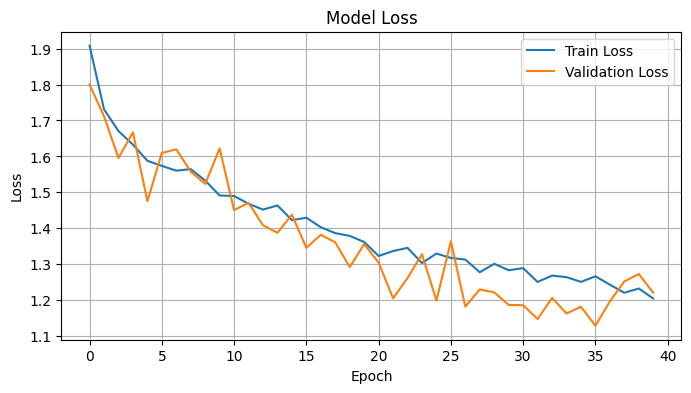

In [31]:
# Plot accuracy
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot loss
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Save the model

In [32]:
model.save("VGG16_skin_lesion_model.keras")

# Load Base Model (DenseNet121)



In [33]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


image_size = (224,224)
image_shape = image_size + (3,)
num_classes = len(df['dx'].unique())

base_model = DenseNet121(
    include_top=False,
    weights='imagenet',
    input_shape=image_shape
)

for layer in base_model.layers:
    layer.trainable = False  # Freeze so weights don’t change during training


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [34]:
base_model.summary()

Model: "densenet121"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 7,037,504 (26.85 MB)

# Add custom classification head

In [35]:
x = base_model.output
x = Flatten()(x)
x = Dense(256,activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(num_classes,activation="softmax")(x)

model = Model(inputs=base_model.input,outputs=output_layer)

# Compile the model

In [36]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

In [37]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 19,884,615 (75.85 MB)

 Trainable params: 12,847,111 (49.01 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

# Add EarlyStopping




In [38]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Model Training

In [39]:
if tf.config.list_physical_devices('GPU'):
  print("GPU Available")

GPU Available


In [40]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=40,
    class_weight=class_weights,
    #callbacks=[early_stop]
)

Epoch 1/40
189/189 ━━━━━━━━━━━━━━━━━━━━ 184s 828ms/step - accuracy: 0.3316 - loss: 2.3588 - val_accuracy: 0.6068 - val_loss: 1.2053
Epoch 2/40
189/189 ━━━━━━━━━━━━━━━━━━━━ 121s 641ms/step - accuracy: 0.5097 - loss: 1.4333 - val_accuracy: 0.5527 - val_loss: 1.2330
Epoch 3/40
189/189 ━━━━━━━━━━━━━━━━━━━━ 119s 630ms/step - accuracy: 0.5074 - loss: 1.3997 - val_accuracy: 0.5000 - val_loss: 1.3745
Epoch 4/40
189/189 ━━━━━━━━━━━━━━━━━━━━ 144s 639ms/step - accuracy: 0.5123 - loss: 1.3938 - val_accuracy: 0.5807 - val_loss: 1.1329
Epoch 5/40
189/189 ━━━━━━━━━━━━━━━━━━━━ 126s 669ms/step - accuracy: 0.5019 - loss: 1.4115 - val_accuracy: 0.6103 - val_loss: 1.0227
Epoch 6/40
189/189 ━━━━━━━━━━━━━━━━━━━━ 118s 626ms/step - accuracy: 0.5460 - loss: 1.3522 - val_accuracy: 0.6224 - val_loss: 1.0232
Epoch 7/40
189/189 ━━━━━━━━━━━━━━━━━━━━ 118s 624ms/step - accuracy: 0.5683 - loss: 1.3082 - val_accuracy: 0.5727 - val_loss: 1.0583
Epoch 8/40
189/189 ━━━━━━━━━━━━━━━━━━━━ 119s 631ms/step - accuracy: 0.5382 -

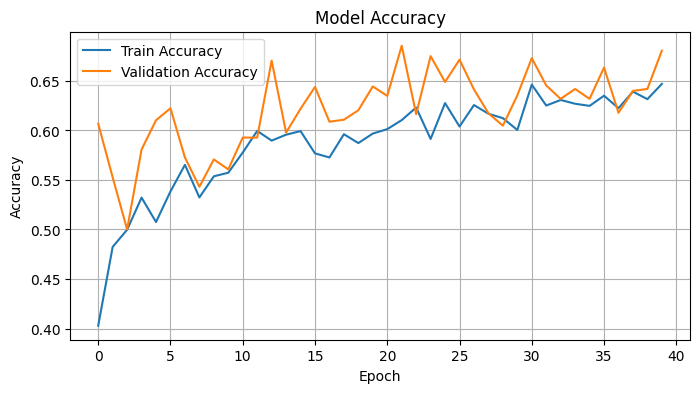

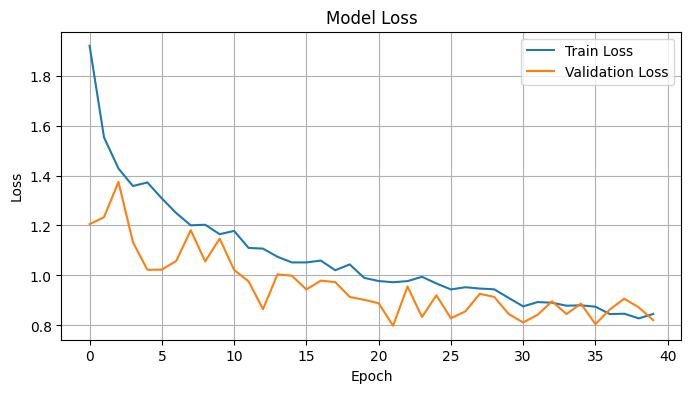

In [41]:
# Plot accuracy
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot loss
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Save the model

In [42]:
model.save("DenseNet121_skin_lesion_model.keras")